In [66]:
import numpy as np
import matplotlib.pyplot as plt

#FFT engines
from numpy.fft import rfftfreq,irfft
#Interpolation
from scipy import interpolate
#Units 
from astropy.units import s,Hz,kHz


# ノイズのパワースペクトルから、実際のnoise todを生成する。
参考　(https://gist.github.com/apetri/3a171080e9eaa987d4cb)

まずはパワースペクトルを定義。

/tmp/ipykernel_580/2747131334.py:16: RuntimeWarning: divide by zero encountered in reciprocal
  return np.clip(PSD_ref * (f / f_ref)**(-alpha), -1, clip_value)


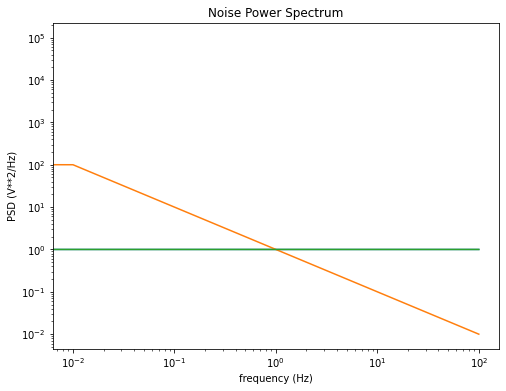

In [67]:
# define noise power spectrum
def white_noise(f, PSD_value):
    """
    f: frequency
    PSD: power specrum density in units of (V**2)/Hz
    """
    return np.ones_like(f) * PSD_value

def pink_noise(f, PSD_ref, f_ref, alpha, clip_value=1e5):
    """
    f: frequency
    f_ref: reference frequency
    PSD_ref: power specrum density at reference frequency
    alpha: power law index
    """
    return np.clip(PSD_ref * (f / f_ref)**(-alpha), -1, clip_value)

f_PSD = np.arange(0, 100.001, 0.01)
PSD_white_noise_model = white_noise(f_PSD, 1)
PSD_pink_noise_model = pink_noise(f_PSD, 1, 1, 1)
PSD_noise_model = PSD_white_noise_model #+ PSD_pink_noise_model

# plot noise power spectrum
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(f_PSD, PSD_white_noise_model, label='white noise')
ax.plot(f_PSD, PSD_pink_noise_model, label='pink noise')
ax.plot(f_PSD, PSD_noise_model, label='noise model')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD (V**2/Hz)')
ax.set_title('Noise Power Spectrum')
ax.set_xscale('log')
ax.set_yscale('log')


In [68]:

#Generate real and imaginary part
#real_part = np.sqrt(0.5*Pf) * np.random.normal(loc=0.0,scale=1.0,size=f.shape)
#imaginary_part = np.sqrt(0.5*Pf) * np.random.normal(loc=0.0,scale=1.0,size=f.shape)
#real_part + imaginary_part*1.0j

N = 4096
fs = 20
T = int(N-1)/fs
t = np.arange(N)/fs

def calc_ft_coef(f, f_PSD, PSD, seed=1234):
    """
    f: frequency
    f_PSD: frequency of noise power spectrum
    PSD: noise power spectrum
    """
    # interpolate noise power spectrum
    PSD_interp = interpolate.interp1d(f_PSD, PSD, kind='linear')(f)

    # set seed
    np.random.seed(seed)
    
    # calculate fourier coefficients
    ft_real_part = np.sqrt(PSD_interp * T * fs**2 / 2) * np.random.normal(loc=0.0,scale=1.0,size=f.shape)
    ft_imag_part = np.sqrt(PSD_interp * T * fs**2 / 2) * np.random.normal(loc=0.0,scale=1.0,size=f.shape)

    ft_coef = ft_real_part + ft_imag_part*1.0j

    return ft_coef

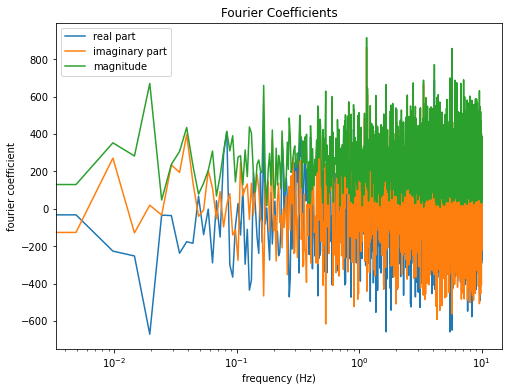

In [69]:
seed = np.random.randint(0, 10000)

f = rfftfreq(N, d=1/fs)
ft_coef = calc_ft_coef(f, f_PSD, PSD_noise_model, seed=seed)
real_part = np.real(ft_coef)
imag_part = np.imag(ft_coef)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(f, real_part, label='real part')
ax.plot(f, imag_part, label='imaginary part')
ax.plot(f, np.abs(ft_coef), label='magnitude')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('fourier coefficient')
ax.set_title('Fourier Coefficients')
ax.set_xscale('log')
ax.legend()

# Convert to TOD

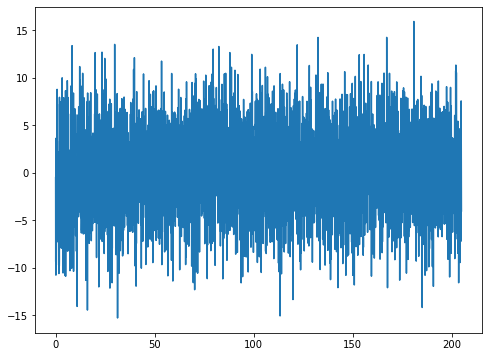

In [70]:
realized_noise = irfft(ft_coef)

fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(t, realized_noise, label='realized noise')




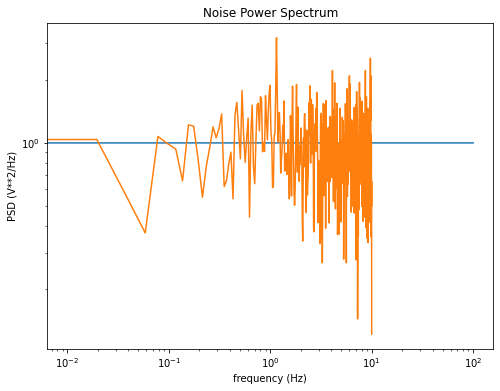

In [73]:
from scipy import signal
f_recover, PSD_recover = signal.welch(realized_noise, fs, nperseg=1024)

# plot noise power spectrum
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.plot(f_PSD, PSD_noise_model, label='noise model')
ax.plot(f_recover, PSD_recover /2, label='realized noise') ####ここのファクター2がよくわからない
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('PSD (V**2/Hz)')
ax.set_title('Noise Power Spectrum')
ax.set_xscale('log')
ax.set_yscale('log')